# Class Challenge: Image Classification of COVID-19 X-rays
# Task 2 [Total points: 30]

## Setup

* This assignment involves the following packages: 'matplotlib', 'numpy', and 'sklearn'. 

* If you are using conda, use the following commands to install the above packages:<br>
```shell
conda install matplotlib
conda install numpy
conda install -c anaconda scikit-learn
```

* If you are using pip, use use the following commands to install the above packages: <br> 
```shell
pip install matplotlib
pip install numpy
pip install sklearn
```

## Data

Please download the data using the following link: [COVID-19](https://drive.google.com/file/d/1Y88tgqpQ1Pjko_7rntcPowOJs_QNOrJ-/view). 

* After downloading 'Covid_Data_GradientCrescent.zip', unzip the file and you should see the following data structure:


|--all<br>
|--------train<br>
|--------test<br>
|--two<br>
|--------train<br>
|--------test<br>


* Put the 'all' folder, the 'two' folder and this python notebook in the **same directory** so that the following code can correctly locate the data.  



## [20 points] Multi-class Classification

#### Load Image Data

In [1]:
import os

import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from keras.callbacks import ModelCheckpoint, EarlyStopping

os.environ['OMP_NUM_THREADS'] = '1'
os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
tf.__version__

'2.8.0'

In [3]:
DATA_LIST = os.listdir('all/train')
DATASET_PATH  = 'all/train'
TEST_DIR =  'all/test'
IMAGE_SIZE    = (224, 224)
NUM_CLASSES   = len(DATA_LIST)
BATCH_SIZE    = 10  # try reducing batch size or freeze more layers if your GPU runs out of memory
NUM_EPOCHS    = 100
LEARNING_RATE = 0.0001 # start off with high rate first 0.001 and experiment with reducing it gradually 

#### Generate Training and Validation Batches

In [5]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=50,featurewise_center = True,
                                   featurewise_std_normalization = True,width_shift_range=0.2,
                                   height_shift_range=0.2,shear_range=0.25,zoom_range=0.1,
                                   zca_whitening = True,channel_shift_range = 20,
                                   horizontal_flip = True,vertical_flip = True,
                                   validation_split = 0.2,fill_mode='constant')


train_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "training",seed=42,
                                                  class_mode="categorical")

valid_batches = train_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  shuffle=True,batch_size=BATCH_SIZE,
                                                  subset = "validation",
                                                  seed=42,class_mode="categorical")

Found 216 images belonging to 4 classes.
Found 54 images belonging to 4 classes.


#### [10 points] Build Model
Hint: Starting from a pre-trained model typically helps performance on a new task, e.g. starting with weights obtained by training on ImageNet. 

In [7]:
#Model 1 using Xception pre-trained model -> 0.71-0.75 test acc
base_model = Xception(weights="imagenet", include_top=False, input_shape=train_batches.image_shape)

model = models.Sequential([
    tf.keras.Model(inputs=base_model.input, outputs=base_model.output, name="xception"),
    layers.GlobalAveragePooling2D(),
    layers.Dense(256, activation='relu', name="dense1"),
    layers.Dropout(0.2, name="dropout1"),
    layers.Dense(4, activation="softmax", name="pred_dense")
])

model.get_layer("xception").trainable=False

#summary of model architecture
model.summary()

#compile the model
model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'],
)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 xception (Functional)       (None, 7, 7, 2048)        20861480  
                                                                 
 global_average_pooling2d_1   (None, 2048)             0         
 (GlobalAveragePooling2D)                                        
                                                                 
 dense1 (Dense)              (None, 256)               524544    
                                                                 
 dropout1 (Dropout)          (None, 256)               0         
                                                                 
 pred_dense (Dense)          (None, 4)                 1028      
                                                                 
Total params: 21,387,052
Trainable params: 525,572
Non-trainable params: 20,861,480
____________________________________

In [6]:
#Model 2 using MobileNet V2 pre-trained model

base_model2 = MobileNetV2(weights="imagenet", include_top=False, input_shape=train_batches.image_shape)

model2 = models.Sequential([
    tf.keras.Model(inputs=base_model2.input, outputs=base_model2.output, name="mobilenet"),
    layers.Flatten(),
    layers.Dense(128, activation='relu', name="dense1"),
    layers.Dropout(0.35, name="dropout1"),
    layers.Dense(4, activation="softmax", name="pred_dense")
])

model2.get_layer("mobilenet").trainable=False

#summary of model architecture
model2.summary()

#compile the model
model2.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=['accuracy'],
)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenet (Functional)      (None, 7, 7, 1280)        2257984   
                                                                 
 flatten (Flatten)           (None, 62720)             0         
                                                                 
 dense1 (Dense)              (None, 128)               8028288   
                                                                 
 dropout1 (Dropout)          (None, 128)               0         
                                                                 
 pred_dense (Dense)          (None, 4)                 516       
                                                                 
Total params: 10,286,788
Trainable params: 8,028,804
Non-trainable params: 2,257,984
_________________________________________________________________


#### [5 points] Train Model

In [ ]:
#add in early stopping and model checkpoint

In [8]:
#FIT MODEL1 - Xception

print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

history = model.fit(train_batches, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_batches, validation_steps=STEP_SIZE_VALID, epochs=NUM_EPOCHS, shuffle=True)

22
6


/share/pkg.7/tensorflow/2.8.0/install/lib/SCC/../python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/share/pkg.7/tensorflow/2.8.0/install/lib/SCC/../python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/100
21/21 [==============================] - 65s 3s/step - loss: 1.3526 - accuracy: 0.3398 - val_loss: 1.1421 - val_accuracy: 0.6600
Epoch 2/100
21/21 [==============================] - 61s 3s/step - loss: 1.1521 - accuracy: 0.5194 - val_loss: 1.0134 - val_accuracy: 0.5600
Epoch 3/100
21/21 [==============================] - 61s 3s/step - loss: 0.9892 - accuracy: 0.6262 - val_loss: 0.9125 - val_accuracy: 0.6400
Epoch 4/100
21/21 [==============================] - 62s 3s/step - loss: 0.9117 - accuracy: 0.6359 - val_loss: 0.9360 - val_accuracy: 0.5800
Epoch 5/100
21/21 [==============================] - 61s 3s/step - loss: 0.8298 - accuracy: 0.6893 - val_loss: 0.8413 - val_accuracy: 0.6400
Epoch 6/100
21/21 [==============================] - 61s 3s/step - loss: 0.8302 - accuracy: 0.6952 - val_loss: 0.8635 - val_accuracy: 0.6000
Epoch 7/100
21/21 [==============================] - 61s 3s/step - loss: 0.7421 - accuracy: 0.7282 - val_loss: 0.8219 - val_accuracy: 0.6200
Epoch 8/100
2

Epoch 59/100
21/21 [==============================] - 62s 3s/step - loss: 0.5322 - accuracy: 0.7913 - val_loss: 0.7087 - val_accuracy: 0.7000
Epoch 60/100
21/21 [==============================] - 62s 3s/step - loss: 0.4967 - accuracy: 0.7864 - val_loss: 0.7129 - val_accuracy: 0.7400
Epoch 61/100
21/21 [==============================] - 64s 3s/step - loss: 0.5179 - accuracy: 0.8048 - val_loss: 0.7799 - val_accuracy: 0.6800
Epoch 62/100
21/21 [==============================] - 61s 3s/step - loss: 0.4746 - accuracy: 0.8107 - val_loss: 0.4889 - val_accuracy: 0.7600
Epoch 63/100
21/21 [==============================] - 62s 3s/step - loss: 0.4484 - accuracy: 0.8155 - val_loss: 0.7426 - val_accuracy: 0.6800
Epoch 64/100
21/21 [==============================] - 61s 3s/step - loss: 0.4519 - accuracy: 0.7913 - val_loss: 0.7112 - val_accuracy: 0.6800
Epoch 65/100
21/21 [==============================] - 62s 3s/step - loss: 0.4640 - accuracy: 0.8107 - val_loss: 0.9041 - val_accuracy: 0.6400
Epoch 

In [7]:
#FIT MODEL2 - MobileNet V2
print(len(train_batches))
print(len(valid_batches))

STEP_SIZE_TRAIN=train_batches.n//train_batches.batch_size
STEP_SIZE_VALID=valid_batches.n//valid_batches.batch_size

NUM_EPOCHS=85

history2 = model2.fit(train_batches, steps_per_epoch=STEP_SIZE_TRAIN, validation_data=valid_batches, validation_steps=STEP_SIZE_VALID, epochs=NUM_EPOCHS)

22
6


/share/pkg.7/tensorflow/2.8.0/install/lib/SCC/../python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:720: UserWarning: This ImageDataGenerator specifies `featurewise_center`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '
/share/pkg.7/tensorflow/2.8.0/install/lib/SCC/../python3.8/site-packages/keras_preprocessing/image/image_data_generator.py:739: UserWarning: This ImageDataGenerator specifies `zca_whitening`, but it hasn't been fit on any training data. Fit it first by calling `.fit(numpy_data)`.
  warnings.warn('This ImageDataGenerator specifies '


Epoch 1/85
21/21 [==============================] - 10s 365ms/step - loss: 2.3634 - accuracy: 0.3204 - val_loss: 1.1026 - val_accuracy: 0.5000
Epoch 2/85
21/21 [==============================] - 7s 316ms/step - loss: 1.4160 - accuracy: 0.4757 - val_loss: 1.1339 - val_accuracy: 0.5000
Epoch 3/85
21/21 [==============================] - 7s 308ms/step - loss: 1.0484 - accuracy: 0.5728 - val_loss: 1.0165 - val_accuracy: 0.5400
Epoch 4/85
21/21 [==============================] - 7s 309ms/step - loss: 0.9338 - accuracy: 0.5728 - val_loss: 0.8498 - val_accuracy: 0.5600
Epoch 5/85
21/21 [==============================] - 7s 308ms/step - loss: 0.9067 - accuracy: 0.6262 - val_loss: 0.7902 - val_accuracy: 0.7000
Epoch 6/85
21/21 [==============================] - 7s 308ms/step - loss: 0.9766 - accuracy: 0.6048 - val_loss: 0.7602 - val_accuracy: 0.6600
Epoch 7/85
21/21 [==============================] - 7s 307ms/step - loss: 0.8574 - accuracy: 0.6117 - val_loss: 0.9741 - val_accuracy: 0.5600
Epoch

21/21 [==============================] - 6s 304ms/step - loss: 0.4614 - accuracy: 0.8286 - val_loss: 0.5730 - val_accuracy: 0.7000
Epoch 59/85
21/21 [==============================] - 6s 295ms/step - loss: 0.4230 - accuracy: 0.8155 - val_loss: 0.6952 - val_accuracy: 0.7000
Epoch 60/85
21/21 [==============================] - 6s 295ms/step - loss: 0.4917 - accuracy: 0.7816 - val_loss: 0.6543 - val_accuracy: 0.7600
Epoch 61/85
21/21 [==============================] - 6s 304ms/step - loss: 0.5154 - accuracy: 0.7864 - val_loss: 0.6671 - val_accuracy: 0.6600
Epoch 62/85
21/21 [==============================] - 6s 303ms/step - loss: 0.4848 - accuracy: 0.7718 - val_loss: 0.5780 - val_accuracy: 0.7000
Epoch 63/85
21/21 [==============================] - 6s 296ms/step - loss: 0.5009 - accuracy: 0.8058 - val_loss: 0.8596 - val_accuracy: 0.6800
Epoch 64/85
21/21 [==============================] - 7s 296ms/step - loss: 0.4953 - accuracy: 0.7961 - val_loss: 0.5970 - val_accuracy: 0.6400
Epoch 65/85

#### [5 points] Plot Accuracy and Loss During Training

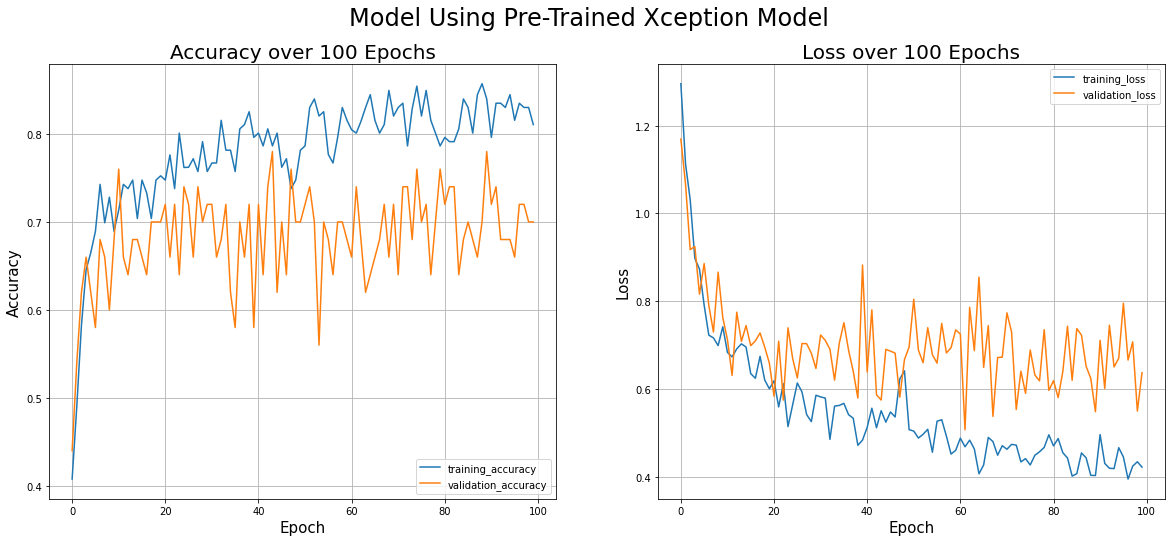

In [10]:
plt.figure(figsize=(20,8))
plt.suptitle("Model Using Pre-Trained Xception Model", fontsize=24)

#plot the accuracies for the training and validation sets
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='training_accuracy')
plt.plot(history.history['val_accuracy'], label = 'validation_accuracy')
plt.title('Accuracy over %s Epochs' % NUM_EPOCHS, fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.grid()
plt.legend(loc='lower right')

#plot the loss for the training and validation sets
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='training_loss')
plt.plot(history.history['val_loss'], label = 'validation_loss')
plt.title('Loss over %s Epochs' % NUM_EPOCHS, fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.grid()
plt.legend(loc='upper right')

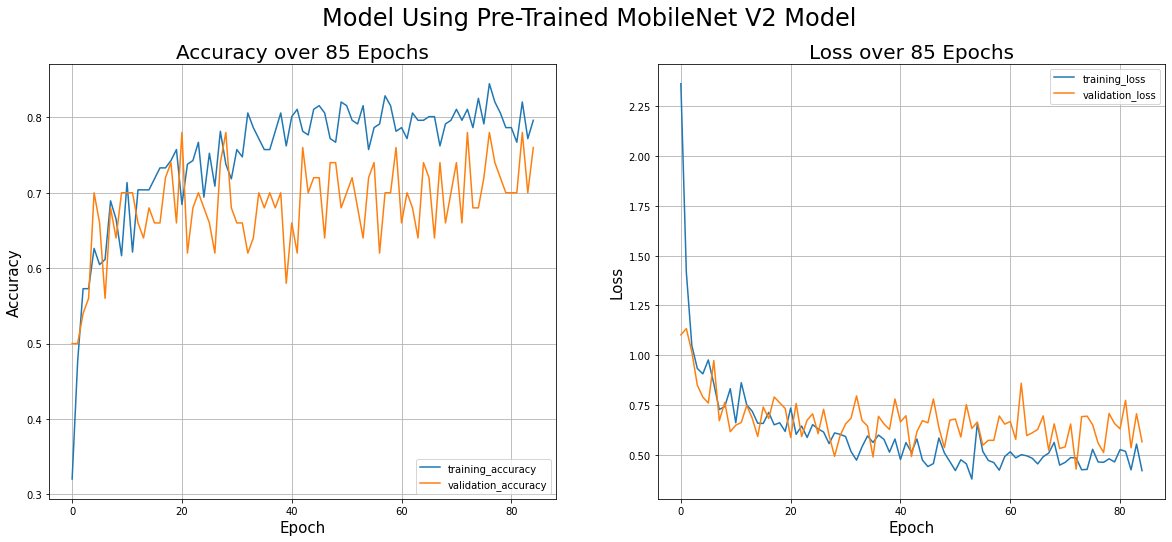

In [8]:
plt.figure(figsize=(20,8))
plt.suptitle("Model Using Pre-Trained MobileNet V2 Model", fontsize=24)

#plot the accuracies for the training and validation sets
plt.subplot(1, 2, 1)
plt.plot(history2.history['accuracy'], label='training_accuracy')
plt.plot(history2.history['val_accuracy'], label = 'validation_accuracy')
plt.title('Accuracy over %s Epochs' % NUM_EPOCHS, fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.grid()
plt.legend(loc='lower right')

#plot the loss for the training and validation sets
plt.subplot(1, 2, 2)
plt.plot(history2.history['loss'], label='training_loss')
plt.plot(history2.history['val_loss'], label = 'validation_loss')
plt.title('Loss over %s Epochs' % NUM_EPOCHS, fontsize=20)
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Loss', fontsize=15)
plt.grid()
plt.legend(loc='upper right')


#### Testing Model

In [12]:
#Accuracy for Model 1 - Xception Pre-Trained Model
print("Model 1: Xception Pre-Trained Model")
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="categorical")
eval_generator.reset()
print(len(eval_generator))
x = model.evaluate(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Model 1: Xception Pre-Trained Model
Found 36 images belonging to 4 classes.
36
36/36 [==============================] - 4s 111ms/step - loss: 0.5150 - accuracy: 0.7778
Test loss: 0.514977753162384
Test accuracy: 0.7777777910232544


In [10]:
#Accuracy for Model 2 - MobileNet V2 Pre-Trained Model
print("Model 2: MobileNet V2 Pre-Trained Model")
test_datagen = ImageDataGenerator(rescale=1. / 255)

eval_generator = test_datagen.flow_from_directory(TEST_DIR,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=True,seed=42,class_mode="categorical")
eval_generator.reset()
print(len(eval_generator))
x = model2.evaluate(eval_generator,steps = np.ceil(len(eval_generator)),
                           use_multiprocessing = False,verbose = 1,workers=1)
print('Test loss:' , x[0])
print('Test accuracy:',x[1])

Model 2: MobileNet V2 Pre-Trained Model
Found 36 images belonging to 4 classes.
36
36/36 [==============================] - 1s 26ms/step - loss: 0.8866 - accuracy: 0.6389
Test loss: 0.8865880966186523
Test accuracy: 0.6388888955116272


## [10 points] TSNE Plot
t-Distributed Stochastic Neighbor Embedding (t-SNE) is a widely used technique for dimensionality reduction that is particularly well suited for the visualization of high-dimensional datasets. After training is complete, extract features from a specific deep layer of your choice, use t-SNE to reduce the dimensionality of your extracted features to 2 dimensions and plot the resulting 2D features.

Found 270 images belonging to 4 classes.


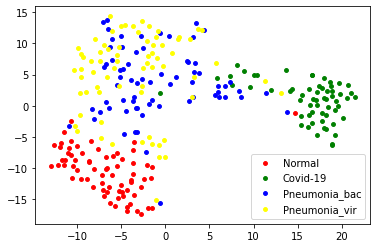

In [13]:
#Model 1 - Xception
from sklearn.manifold import TSNE

intermediate_layer_model = models.Model(inputs=model.input,
                                        outputs=model.get_layer('dense1').output)

tsne_eval_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="categorical")

# raise NotImplementedError("Extract features from the tsne_data_generator and fit a t-SNE model for the features,"
#                           "and plot the resulting 2D features of the four classes.")

features = intermediate_layer_model.predict(tsne_eval_generator)
label = tsne_eval_generator.class_indices

classes = tsne_eval_generator.classes
fea_tsne = TSNE(learning_rate=50).fit_transform(features)
X,Y = zip(*fea_tsne)

X_Nor=[]
Y_Nor=[]

X_Cov=[]
Y_Cov=[]

X_Bac=[]
Y_Bac=[]

X_Vir=[]
Y_Vir=[]

for x,y,c in zip(X,Y,classes):
    if(label['covid']==c):
        X_Cov.append(x)
        Y_Cov.append(y)
    elif(label['normal']==c):
        X_Nor.append(x)
        Y_Nor.append(y)
    elif(label['pneumonia_bac']==c):
        X_Bac.append(x)
        Y_Bac.append(y)
    else:
        X_Vir.append(x)
        Y_Vir.append(y)
        
plt.scatter(X_Nor, Y_Nor, c='red', label='Normal', s=15)
plt.scatter(X_Cov, Y_Cov, c='green', label='Covid-19', s=15)
plt.scatter(X_Bac, Y_Bac, c='blue', label='Pneumonia_bac', s=15)
plt.scatter(X_Vir, Y_Vir, c='yellow', label='Pneumonia_vir', s=15)

plt.legend()
plt.show()

Found 270 images belonging to 4 classes.


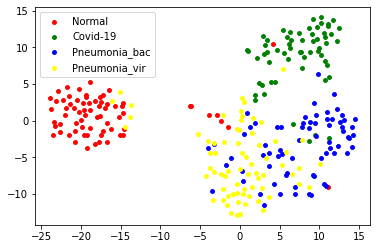

In [11]:
#Model 2 - MobileNet V2
from sklearn.manifold import TSNE

intermediate_layer_model = models.Model(inputs=model2.input,
                                        outputs=model2.get_layer('dense1').output)

tsne_eval_generator = test_datagen.flow_from_directory(DATASET_PATH,target_size=IMAGE_SIZE,
                                                  batch_size=1,shuffle=False,seed=42,class_mode="categorical")

# raise NotImplementedError("Extract features from the tsne_data_generator and fit a t-SNE model for the features,"
#                           "and plot the resulting 2D features of the four classes.")

features = intermediate_layer_model.predict(tsne_eval_generator)
label = tsne_eval_generator.class_indices

classes = tsne_eval_generator.classes
fea_tsne = TSNE(learning_rate=50).fit_transform(features)
X,Y = zip(*fea_tsne)

X_Nor=[]
Y_Nor=[]

X_Cov=[]
Y_Cov=[]

X_Bac=[]
Y_Bac=[]

X_Vir=[]
Y_Vir=[]

for x,y,c in zip(X,Y,classes):
    if(label['covid']==c):
        X_Cov.append(x)
        Y_Cov.append(y)
    elif(label['normal']==c):
        X_Nor.append(x)
        Y_Nor.append(y)
    elif(label['pneumonia_bac']==c):
        X_Bac.append(x)
        Y_Bac.append(y)
    else:
        X_Vir.append(x)
        Y_Vir.append(y)
        
plt.scatter(X_Nor, Y_Nor, c='red', label='Normal', s=15)
plt.scatter(X_Cov, Y_Cov, c='green', label='Covid-19', s=15)
plt.scatter(X_Bac, Y_Bac, c='blue', label='Pneumonia_bac', s=15)
plt.scatter(X_Vir, Y_Vir, c='yellow', label='Pneumonia_vir', s=15)

plt.legend()
plt.show()

<!-- ## Task 2: COVID-19 vs Normal vs Tertiary Pneumonia (Bacterial and Viral) -->

<!-- #### Renew Training Batch and Validation Batch -->

<!-- #### Renew Model -->